In [13]:
import pprint 

In [18]:
from scipy import io

In [23]:
from matplotlib.pyplot import imshow

In [11]:

import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [15]:
class CONFIG:                  #Class is like an object constructor
    IMAGE_WIDTH = 1280
    IMAGE_HEIGHT = 720
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.5
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

In [21]:
import scipy.io
import imageio
import scipy.misc

In [19]:
def load_vgg_model(path):
    vgg = io.loadmat(path)
    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b
        return W, b
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)
    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b
    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [20]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor: shape=(1, 360, 640, 64), dtype=float32, numpy=
array([[[[0.30172518, 0.28211468, 2.4223387 , ..., 1.0978045 ,
          0.69431424, 1.1990573 ],
         [0.42363834, 0.56422937, 2.929647  , ..., 1.4904122 ,
          0.85025406, 1.33372   ],
         [0.42363834, 0.56422937, 2.929647  , ..., 1.4904122 ,
          0.85025406, 1.33372   ],
         ...,
         [0.42363834, 0.56422937, 2.929647  , ..., 1.4904122 ,
          0.85025406, 1.33372   ],
         [0.42363834, 0.56422937, 2.929647  , ..., 1.4904122 ,
          0.85025406, 1.33372   ],
         [0.45847642, 0.75582504, 2.4548829 , ..., 1.3755591 ,
          0.82044655, 0.8522244 ]],

        [[0.5808617 , 0.56422937, 2.9793446 , ..., 1.6307087 ,
          0.75949955, 0.6912922 ],
         [0.8020994 , 1.1284587 , 3.6142712 , ..., 2.160086  ,
          0.9419428 , 0.71724075],
         [0.8020994 , 1.1284587 , 3.6142712 , ..., 2.160086  ,
          0.9419428 , 0.71724075],
         ...,
         [0.8

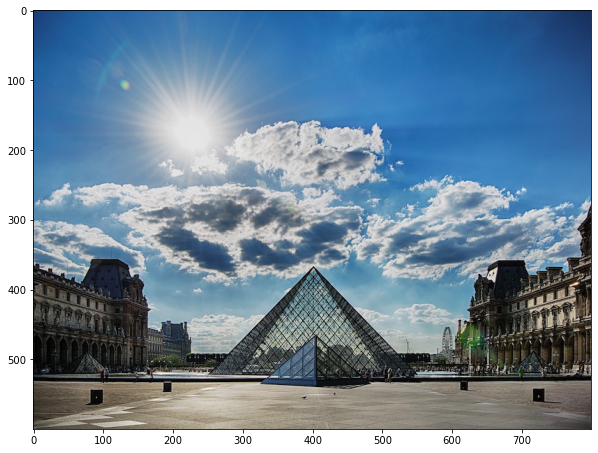

In [25]:
import imageio
content_image = imageio.imread("images/louvre.jpg")
plt.figure(figsize=(10,10))
plt.imshow(content_image);

In [26]:
content_image.shape

(600, 800, 3)

In [27]:
def compute_content_cost(a_C,a_G):
    #Retrieve dimensions from a_G
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    #Unrolled a_C and a_G
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    
    #Compute the Content Cost
    j_content = (1/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))))

    return j_content

In [ ]:
import imageio
content_image = imageio.imread("images/louvre.jpg")
plt.figure(figsize=(10,10))
plt.imshow(content_image);

(300, 400, 3)

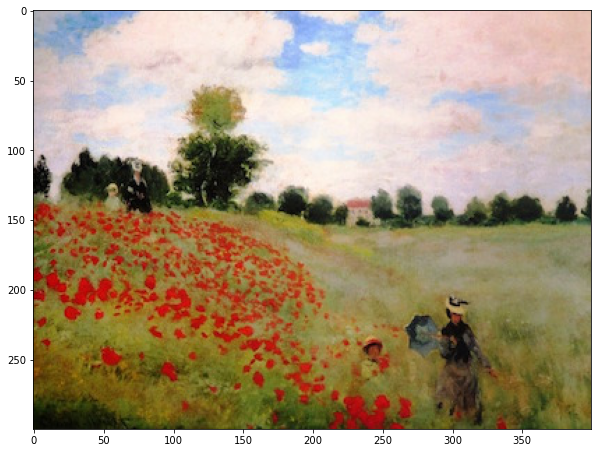

In [29]:
style_image = imageio.imread("images/monet.jpg")
plt.figure(figsize=(10,10))
plt.imshow(style_image)
style_image.shape

In [30]:
# Style Matrix is also known as Gram Matrix, Gij which is the dot product of np.dot(vi,vj). Gij compares how similar vi to vj if it is similar then dot product to be very high.
# In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose.
# The result is a matrix of dimension (n_C,n_C) where n_C is the number of filters (channels).
# The diagonal elements  G(gram)ii  measure how "active" a filter  i  is.
# For example, suppose filter i is detecting vertical textures in the image. Then  G(gram)i  measures how common vertical textures are in the image as a whole.
# If  G(gram)ii is large, this means that the image has a lot of vertical texture

In [31]:
### Computing Cost for a single layer
def compute_style_cost_layer(a_S,a_G):
    #Retrieve dimensions from a_G
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    #unroll a_S and a_G
    a_S = tf.transpose(tf.reshape(a_S,shape=[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape=[n_H*n_W,n_C]))
    
    #Computing gram matrics
    S = tf.matmul(a_S,tf.transpose(a_S))
    G = tf.matmul(a_G,tf.transpose(a_G))
    
    #Compute the Style Cost
    j_style_layer = (1/(4*(n_C**2)*((n_H*n_W)**2)))*(tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(S,G)))))
    
    return j_style_layer

In [32]:
# We have captured the style from only one layer.
# We'll get better results if we "merge" style costs from several different layers.
# Each layer will be given weights (λ[l]) that reflect how much each layer will contribute to the style.

In [33]:
style_layers = [('conv1_2',0.3),
               ('conv3_2',0.3),
               ('conv3_3',0.3),
               ('conv4_2',0.3),
               ('conv5_1',0.3)]

In [55]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [35]:
#compute total cost
#alpha and beta are the hypermeters that control the weights between content and style. 


def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    

    J = alpha * J_content + beta * J_style

    
    return J

In [56]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

import tensorflow.compat.v1 as f
sess = f.Session()
with sess as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [58]:

# Reset the graph
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

# Start interactive session
sess = tf.compat.v1.InteractiveSession()

C:\Users\soumya.sinha\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [36]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()
#  Reshape and normalize the input image (content or style)
def reshape_and_normalize_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    image = image - CONFIG.MEANS
    return image

In [59]:
content_image = imageio.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

In [60]:

style_image = imageio.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

In [61]:
style_image.shape

(1, 300, 400, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


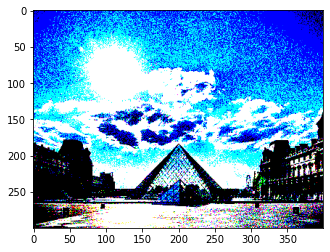

In [62]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);